In [181]:
import os 
import shutil
import torch 
from torch.utils.data import DataLoader, Dataset 
from torchvision.models import resnet18
# from torchvision.models import save_image
from torchvision import transforms 
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.optim.lr_scheduler import StepLR 
from pytorch_fid import fid_score

import shutil 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

# Image processing 
import pandas as pd 
import numpy as np 
from PIL import Image 
import cv2 

# Data visualisation 
import matplotlib.pyplot as plt 
from deap import base, creator, tools, algorithms 
from tabulate import tabulate

## BicycleGAN 

Since this project is focused on integration, the complete model is simpler and more efficient to use than the state_dict model. Iteration 12 model will be used as per our evaluation.

In [146]:
# Define Encoder with corrected linear layer sizes
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )

        # Example input size
        self.example_input = torch.randn(1, 3, 256, 256)
        self._initialize()

    def _initialize(self):
        with torch.no_grad():
            x = self.example_input
            x = self.model(x)  # Forward pass to get output shape
            self.flattened_size = x.view(-1).size(0)
            self.fc_mu = nn.Linear(self.flattened_size, 128)
            self.fc_logvar = nn.Linear(self.flattened_size, 128)

    def forward(self, x):
        x = self.model(x)  
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define Generator and Discriminator classes
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()

        # Encoder (Downsampling)
        self.enc1 = self.contracting_block(in_channels, 64)  # [64, 128, 128]
        self.enc2 = self.contracting_block(64, 128)  # [128, 64, 64]
        self.enc3 = self.contracting_block(128, 256)  # [256, 32, 32]
        self.enc4 = self.contracting_block(256, 512)  # [512, 16, 16]

        # Bottleneck
        self.bottleneck = self.contracting_block(512, 1024)  # [1024, 8, 8]

        # Decoder (Upsampling)
        self.dec4 = self.expansive_block(1024, 512)  # [512, 16, 16]
        self.dec3 = self.expansive_block(512, 256)  # [256, 32, 32]
        self.dec2 = self.expansive_block(256, 128)  # [128, 64, 64]
        self.dec1 = self.expansive_block(128, 64)  # [64, 128, 128]

        # Final output layer
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),  # [3, 256, 256]
            nn.Tanh()  # Ensures output is in range [-1, 1]
        )

    def contracting_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(0.5),
        )
        return block

    def expansive_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )
        return block

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decoder with skip connections
        dec4 = self.dec4(bottleneck) + enc4  
        dec3 = self.dec3(dec4) + enc3  
        dec2 = self.dec2(dec3) + enc2  
        dec1 = self.dec1(dec2) + enc1  

        # Final output
        final_output = self.final_layer(dec1)
        return final_output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define BicycleGAN model with U-Net Generator (need to match original architecture)
class BicycleGAN(nn.Module):
    def __init__(self):
        super(BicycleGAN, self).__init__()
        self.generator = UNetGenerator()
        self.encoder = Encoder()  # Using the existing Encoder
        self.discriminator = Discriminator()  # Using the existing PatchGAN Discriminator

    def forward(self, x):
        generated_images = self.generator(x)
        mu, logvar = self.encoder(generated_images)
        return generated_images, mu, logvar

In [147]:
# Instantiate and load the model
bicyclegan_model = BicycleGAN()
bicyclegan_model_path = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\model_12_completeModel.pth'
bicyclegan_model = torch.load(bicyclegan_model_path)
bicyclegan_model.eval()  # Set the model to evaluation mode
# bicyclegan_model.load_state_dict(torch.load(bicyclegan_model_path))
# bicyclegan_model.eval()

C:\Users\cecilia\AppData\Local\Temp\ipykernel_25708\4157990216.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bicyclegan_model = torch.load(bicyclegan_model_path)


BicycleGAN(
  (generator): UNetGenerator(
    (enc1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
    )
    (enc2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
    )
    (enc3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
    )
    (enc4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
    )
    (bottleneck): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
    )
    (dec4): Sequential(
      (0): ConvTranspose2d(1024

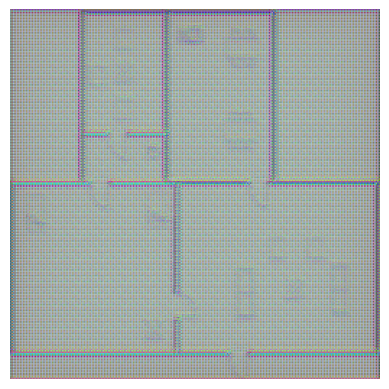

In [148]:
def generate_floor_plan(bicyclegan_model, input_image_path):
    # Load and preprocess input image
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    input_image = Image.open(input_image_path).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension

    # Generate floor plan
    with torch.no_grad():
        generated_output = bicyclegan_model(input_tensor)
    generated_image = generated_output[0].squeeze(0)  # Remove batch dimension
    generated_image = (generated_image * 0.5 + 0.5).clamp(0, 1)  # Unnormalize
    generated_image_pil = transforms.ToPILImage()(generated_image)
    return generated_image_pil

def visualize_image(image):
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()

def save_image(image, output_path):
    image.save(output_path)


# input_image_path = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\test\input\Cat42_8.jpg'  
input_image_path = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\train\input\cat44_6.jpg'
generated_image_pil = generate_floor_plan(bicyclegan_model, input_image_path)


# Output folder path 
output_folder_path = output_folder_path = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\generated_floor_plans'

# display the generated image 
visualize_image(generated_image_pil)

# define the output file path 
output_file_path = os.path.join(output_folder_path, 'generated_floor_plan_8.png') 

# save the generated image 
save_image(generated_image_pil, output_file_path)

## Genetic algorithm 
Combine BicycGAN output with GA optimisation. Once the BicycleGAN generates the floor plan, it will be passed as in input to the Genetic Algorithm. 

- The GA starts by generating a population of plant placements.
- The fitness function evaluates each solution based on predefined rules.
- The GA runs for a set number of 100 generations, optimising plant placement by crossover and mutation.

Iteration 4 model will be used as per the evaluation.

In [153]:
# Load the Bagua map
bagua_map_path = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\blackHatBaguaMap.jpg'
bagua_map = cv2.imread(bagua_map_path) 

# Define the output folder path
output_folder_path = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\generated_floor_plans'

# Define the filename of the generated image you want to load
generated_image_filename = 'generated_floor_plan_5.png'
generated_image_path = os.path.join(output_folder_path, generated_image_filename)

# Load the generated image from the file path
generated_image_pil = Image.open(generated_image_path)

# Convert PIL image to numpy array for further processing
generated_image_np = np.array(generated_image_pil)

# print(f'Image dimensions: {height} x {width}')



1. Preprocessing of the bagua map: Detect the front door, align the map, and overlay it on the floor plan.
2. Detect green areas: This will define the areas where the plants can be placed.
3. Run the genetic algorithm: Use the green areas and other constraints (door distance, corner distance, sunlight) as evaluation criteria in the GA


In [155]:
def detect_main_door(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to binary
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours of shapes in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to store door contours
    door_contours = []

    # Iterate through contours
    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the contour is a quarter circle
        if len(approx) >= 5:  # Check if it's a curve (a quarter circle approximation)
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * area / (perimeter * perimeter)

            # circularity threshold based on quarter circle shape
            if 0.6 < circularity < 0.9:
                door_contours.append(contour)

    # Return the contours of detected doors
    return door_contours

def find_front_door(image):
    door_contours = detect_main_door(image)

    if len(door_contours) != 1:
        print(f"Error: Detected {len(door_contours)} doors instead of 1.")
        return None  # Return None if there's not exactly one main door

    # Get the bounding box of the detected door contour
    x, y, w, h = cv2.boundingRect(door_contours[0])

    # Return the center of the detected door as the front door location
    front_door_x = x + w // 2
    front_door_y = y + h // 2
    return front_door_x, front_door_y


In [156]:
# Function to align BTB map with the front door of the floor plan
def align_btb_map_with_front_door(floor_plan, btb_map):
    front_door_coords = find_front_door(floor_plan)
    if front_door_coords is None:
        raise ValueError("No front door detected or multiple doors detected in the floor plan.")

    front_door_x, front_door_y = front_door_coords
    height, width, _ = floor_plan.shape

    # Resize BTB map to match the floor plan size
    btb_map_resized = cv2.resize(btb_map, (width, height))

    # Align BTB map so its north direction matches the front door
    btb_map_center_x = width // 2
    btb_map_center_y = 0  # Assuming north is at the top

    # Calculate the shifts needed to align the BTB map
    shift_x = front_door_x - btb_map_center_x
    shift_y = front_door_y - btb_map_center_y

    # Create the translation matrix
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

    # Apply the translation to the BTB map
    aligned_btb_map = cv2.warpAffine(btb_map_resized, translation_matrix, (width, height))

    return aligned_btb_map


def overlay_btb_map(floor_plan, aligned_btb_map):
    overlay = cv2.addWeighted(floor_plan, 0.7, aligned_btb_map, 0.3, 0)
    return overlay


In [157]:
def detect_green_areas_and_draw_rectangles_bgr2gray(overlay_image):
    # Convert the overlay image to grayscale
    gray_image = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to get only green areas
    _, thresholded = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    # Find contours of green areas
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw green rectangles around detected green areas
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(overlay_image, (x, y), (x + w, y + h), (0, 255, 0), 10)  # Green rectangle

    return overlay_image

In [158]:
def display_image(image, title='Image'):
    """Function to display an image using matplotlib."""
    # Convert BGR image (OpenCV format) to RGB format (matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 10))
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [159]:
if bagua_map is not None:
    floor_plans = [f for f in os.listdir(output_folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    if len(floor_plans) >= 11:
        # Process a specific floor plan
        floor_plan_filename = floor_plans[10]  # Ensure there are at least 11 floor plans
        image_path = os.path.join(output_folder_path, floor_plan_filename)
        floor_plan = cv2.imread(image_path)

        if floor_plan is not None:
            try:
                # Align BTB map with front door of floor plan
                aligned_btb_map = align_btb_map_with_front_door(floor_plan, bagua_map)

                # Overlay the aligned BTB map on the floor plan
                overlay_image = overlay_btb_map(floor_plan, aligned_btb_map)

                # Detect green areas and draw rectangles
                result_image = detect_green_areas_and_draw_rectangles_bgr2gray(overlay_image)

                # Display the result
                display_image(result_image, 'Floor Plan with Detected Green Areas')
            except ValueError as e:
                print(f"Error processing {floor_plan_filename}: {e}")
    else:
        print("Not enough floor plans found in the specified folder.")
else:
    print("BTB Map image not found.")

Error: Detected 0 doors instead of 1.
Error processing generated_floor_plan_7.jpg: No front door detected or multiple doors detected in the floor plan.


gen	nevals	avg    	std    	min    	max    
0  	10    	2.72775	1.39848	0.74836	4.64435
1  	3     	3.68911	1.07015	1.70382	5.13352
2  	6     	4.50112	0.970345	3.05327	6.50479
3  	8     	5.07105	0.891282	3.26869	6.50479
4  	7     	5.43442	0.91401 	3.90356	6.50479
5  	9     	6.01039	0.725042	4.10831	6.50479
6  	5     	6.47678	0.143307	6.08569	6.69679
7  	6     	6.19033	0.738817	4.4684 	6.69679
8  	7     	6.4692 	0.55594 	5.31309	7.49364
9  	8     	6.1872 	0.969865	4.72411	7.49364
10 	7     	6.95548	0.805677	4.88659	7.49364
11 	3     	7.22332	0.810953	4.79046	7.49364
12 	7     	7.36411	0.388588	6.19835	7.49364
13 	6     	7.36744	0.252915	6.82659	7.49364
14 	5     	7.45898	0.103978	7.14705	7.49364
15 	9     	7.16098	0.534743	5.90485	7.49364
16 	2     	7.33878	0.46459 	5.945  	7.49364
17 	6     	7.08168	0.890152	5.17773	7.73871
18 	4     	7.59167	0.120062	7.49364	7.73871
19 	5     	7.62375	0.230302	7.13493	7.73871
20 	9     	7.20579	0.915004	5.23017	7.73871
21 	6     	7.26146	1.03026 	4.48542

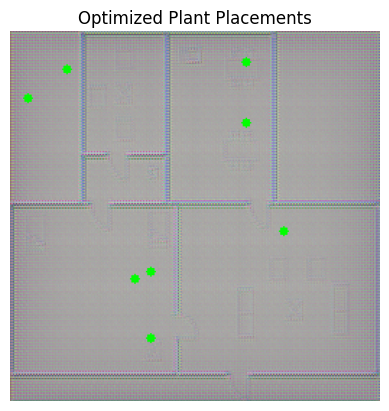

In [180]:
# Constants
NUM_PLANTS = 8
POP_SIZE = 10
NGEN = 100
CXPB, MUTPB = 0.5, 0.2
DOOR_DISTANCE_THRESHOLD = 50  # Plants at least 20 pixels away from doors
CORNER_DISTANCE_THRESHOLD = 50  # Plants within 50 pixels of room corners
SUNLIGHT_MAP = np.random.rand(height, width)  # Placeholder for sunlight availability map

# Extract height and width from floor_plan
height, width, _ = generated_image_np.shape # Extract width here

green_areas = np.zeros((height, width), dtype=np.uint8)

# Mock doors locations for demonstration
doors = [(100, 100), (200, 200)]

# DEAP setup
if not hasattr(creator, 'FitnessMax'):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_pos", lambda: (random.randint(0, width-1), random.randint(0, height-1)))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_pos, n=NUM_PLANTS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness evaluation function
def evaluate(individual):
    score = 0
    for pos in individual:
        x, y = pos

        # Reward if placed in green area
        if green_areas[y, x] == 1:
            score += 1

        # Penalize if too close to a door
        for door in doors:
            if np.linalg.norm(np.array(pos) - np.array(door)) < DOOR_DISTANCE_THRESHOLD:
                score -= 1

        # Reward if placed near a corner (Example using the top-left corner)
        if np.linalg.norm(np.array(pos)) < CORNER_DISTANCE_THRESHOLD:
            score += 1

        # Reward based on sunlight availability
        score += SUNLIGHT_MAP[y, x]  # Assuming higher values mean more sunlight

        # Below is for more criteria to be added
    return score,


toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("select", tools.selTournament, tournsize=3)

# Custom mutation function to respect (x, y) tuple structure
def custom_mutation(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = (random.randint(0, width-1), random.randint(0, height-1))
    return individual,

toolbox.register("mutate", custom_mutation, indpb=0.2)

# Running the Genetic Algorithm
def run_ga():
    population = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, log = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                          stats=stats, halloffame=hof, verbose=True)

    return population, log, hof

# Visualization function
def visualize_layout(generated_image_np, layout):
    # Display a copy of the floor plan to draw on
    display_plan = generated_image_np.copy()

    # Optional: Enhance floor plan visibility if it's too light
    display_plan = cv2.addWeighted(display_plan, 0.7, np.zeros_like(display_plan), 0, 50)

    # overlay the plant placements on the floor plan
    for x, y in layout:
        cv2.circle(display_plan, (x, y), 3, (0, 255, 0), -1)  # green circles for plant placements

    # Display the image with both the floor plan and the plants
    plt.imshow(cv2.cvtColor(display_plan, cv2.COLOR_BGR2RGB))
    plt.title('Optimized Plant Placements')
    plt.axis('off')
    plt.show()

# Main Execution
population, logs, hall_of_fame = run_ga()
best_layout = hall_of_fame[0]

# Visualize the best layout on the actual floor plan
visualize_layout(generated_image_np, best_layout)

^ Above is the generated and optimised output after combining BicycleGAN model with Genetic Algorithm model for generation and optimisation process of this project. 

Explanation:

1. The bicyclegan model generates the room layout, which is passed to the ga
2. The genetic algorithm optimises plant placements on the generated floor plan.
3. Finally, the optimised plant placements are drawn on the generated floor plan and saved as in image

Conclusion: 
- Generate the room layout using bicyclegan
- optimise the plant placement using a genetic algorithm that takes the generated floor plan as input. 